In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from xbbg import blp
import pdblp
import workdays
import datetime
import time

Reference: EQ=83, SB=120, FX=11or85


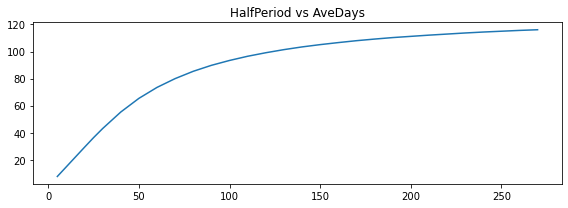

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
HalfPeriod,5.0,10.0,15.0,20.0,25.0,30.0,40.0,50.0,60.0,70.0,...,180.0,190.0,200.0,210.0,220.0,230.0,240.0,250.0,260.0,270.0
Ave,7.7,14.9,22.1,29.3,36.4,43.1,55.3,65.4,73.5,80.0,...,109.2,110.3,111.2,112.1,112.9,113.7,114.4,115.0,115.6,116.1
Diff,0.0,7.2,7.2,7.2,7.1,6.7,12.2,10.1,8.1,6.5,...,1.2,1.1,0.9,0.9,0.8,0.8,0.7,0.6,0.6,0.5


In [2]:
p = 260
H = [10,20,40,60,120,260]
H = [5,10,15,20,25] + list(range(30,280,10))

tmp = pd.DataFrame(index=["HalfPeriod","Ave"])
tmp = pd.DataFrame( np.zeros([1,len(H)]),  index=["HalfPeriod"] )
tmp.loc["HalfPeriod",:] = H

for j,h in enumerate(H):
    v = 0.5 ** (np.arange(p,0,-1)/h)
    v /= sum(v)    
    tmp.loc["Ave",j] = round( v @ list(range(p,0,-1)) ,1)

tmp.loc["Diff",:] = 0 
for j in range(1,len(H)):
    tmp.loc["Diff",j] = tmp.loc["Ave",j]  - tmp.loc["Ave",j-1] 

fig, ax = plt.subplots(1, 1, squeeze=False,figsize=(8,3),tight_layout=True)
ax[0,0].plot(tmp.iloc[0,:], tmp.iloc[1,:])
ax[0,0].set_title("HalfPeriod vs AveDays")

print("Reference: EQ=83, SB=120, FX=11or85")
plt.show()
tmp

Past 260 days, half-life 20 days


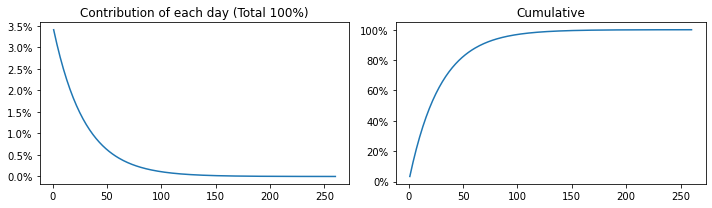

In [3]:

def f(p,h):
    v = 0.5 ** ( (np.arange(p,0,-1)-1)/h)
    v = v/sum(v)
    v = [i for i in  reversed(v)]
    
    fig, ax = plt.subplots(1, 2, squeeze=False,figsize=(10,3),tight_layout=True)
    ax[0,0].plot(range(1,len(v)+1), v)
    ax[0,0].set_title("Contribution of each day (Total 100%)")
    ax[0,0].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1,1))
    
    ax[0,1].plot(range(1,len(v)+1), np.cumsum(v))
    ax[0,1].set_title("Cumulative")
    ax[0,1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1,0))
    
    return v

p = 260
h = 20
v = f(p,h)

print("Past " + str(p) + " days, half-life " + str(h) + " days")
plt.show()

In [4]:
con = pdblp.BCon(timeout=5000)
con.start()

T = ["ES1 Index","TY1 Comdty","JPY Curncy"] #Ticker
L = ["ES","TY","JPY"] #Symbol
    
# d_from = 19960628
d_from = workdays.workday(datetime.datetime.today(), days=-1000).strftime("%Y%m%d")
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime("%Y%m%d")

df = con.bdh(T, ["px_last"], d_from, d_to).reset_index()
df.columns = ["Date"] + L

for j in range(len(L)):    
    df[L[j]+"_RetD"] = df[L[j]].pct_change()

In [5]:
# r_from = df.query('Date == "2007-03-30"').index[0]
r_from = 600


def SD(p, h): 
    v = 0.5 ** ( (np.arange(p,0,-1)-1)/h)
    v = v/sum(v)

    for j in L:
        tmp1 = j+"_SD"+str(h)
        
        tmp_SD = [0]*len(df)
        tmp_DR = df[j+"_RetD"].values
        for i in range(r_from-270,len(df)):
            tmp = tmp_DR[i-p+1:i+1]**2 @ v - (tmp_DR[i-p+1:i+1] @ v)**2
            tmp_SD[i] = ( tmp * 260 )**0.5

        df[tmp1] = tmp_SD
        
        
def Cov(p,h): 
    v = 0.5 ** ( (np.arange(p,0,-1)-1)/h)
    v = v/sum(v)

    for j in range(len(L)):
        for k in range(j+1,len(L)):
            tmp1 = L[j]+"-"+L[k]+"_Cov"+str(h)
            tmp2 = L[j]+"-"+L[k]+"_Cor"+str(h)

            tmp_Cov = [0]*len(df)
            tmp_Cor = [0]*len(df)
            
            tmp_DR = df[[x+"_RetD" for x in L]].values
            tmp_SD = df[[x+"_SD"+str(h) for x in L]].values
            
            for i in range(r_from-1,len(df)):
                tmp = (tmp_DR[i-p+1:i+1,j] * tmp_DR[i-p+1:i+1,k] ) @ v
                tmp -= (tmp_DR[i-p+1:i+1,j]  @ v ) * (tmp_DR[i-p+1:i+1,k] @ v )
                tmp *= 260

                tmp_Cov[i] = tmp
                tmp_Cor[i] = tmp  / tmp_SD[i,j] / tmp_SD[i,k]

            df[tmp1] = tmp_Cov
            df[tmp2] = tmp_Cor
            
            
def HR(p, h): 
    v = 0.5 ** ( (np.arange(p,0,-1)-1)/h)
    v = v/sum(v)

    for l in L:
        tmp1 = l + "_HR"+str(h)
        tmp_HR = [0]*len(df)
        tmp_DR = df[l+"_RetD"].values
        
        for i in range(r_from-1,len(df)):
            tmp = list(tmp_DR[i-p+1:i+1]) @ v
            tmp_HR[i] = (1+tmp)**260 - 1
            
            tmp = 1
            for j in range(p):
                tmp *= (1+tmp_DR[i-p+1+j]) ** v[j]
            tmp_HR[i] = tmp**260 - 1
            
        df[tmp1] = tmp_HR

In [6]:
t0 = time.time()
H = [5,10]
for h in range(len(H)):
    SD(260, H[h])
    print(str(h+1)+"/"+str(len(H)),str( round((time.time() - t0)/60,1)) + " minutes")

1/2 0.0 minutes
2/2 0.0 minutes


In [7]:
t0 = time.time()
H = [5,10]
for h in range(len(H)):
    Cov(260, H[h])
    print(str(h+1)+"/"+str(len(H)),str( round((time.time() - t0)/60,1)) + " minutes")

1/2 0.0 minutes
2/2 0.0 minutes


In [8]:
t0 = time.time()

H = [5,10]
for h in range(len(H)):
    
    HR(260,H[h])       
    print( str(h+1)+"/"+str(len(H)),str( round((time.time() - t0)/60,1)) + " minutes")

1/2 0.0 minutes
2/2 0.0 minutes


In [9]:
df[["Date","ES_SD10","ES-TY_Cov10","ES_HR10"]]

,Date,ES_SD10,ES-TY_Cov10,ES_HR10
0,2019-10-07,0.000000,0.000000,0.000000
1,2019-10-08,0.000000,0.000000,0.000000
2,2019-10-09,0.000000,0.000000,0.000000
3,2019-10-10,0.000000,0.000000,0.000000
4,2019-10-11,0.000000,0.000000,0.000000
...,...,...,...,...
995,2023-07-31,0.087508,0.002950,0.526812
996,2023-08-01,0.086464,0.003063,0.411673
997,2023-08-02,0.103700,0.002832,0.080914
998,2023-08-03,0.101293,0.002902,0.013099
